In [1]:
import ROOT
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split
import tensorflow as tf

Welcome to JupyROOT 6.30/02


2024-02-09 09:23:19.977228: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-09 09:23:23.654857: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Setting ATLAS style


Info in <TStyle::configure>: Configuring default ATLAS style


Setting ATLAS style


Info in <TStyle::configure>: Configuring default ATLAS style


In [2]:
#load int data
read_emu = "output_emu_mc16d.h5"

with h5py.File(read_emu, 'r') as f:
    events_emu = f['events'][:]  #this contains 4-vector info from leading 2bjets, 1e and 1mu per event. (so (pt, eta, phi, e))
    X_emu = f['X_emu'][:]  #input for ML
    Y_emu = f['Y_emu'][:]  #target variable for ML (truth m_ttbar)
    m_bbll = f['m_bbll'][:] 
    
#print(events_emu.shape, X_emu.shape, Y_emu.shape, m_bbll.shape)
#combine the 4-vector info with X_emu to make it (N_evt, 24) input
events_emu = events_emu.reshape(events_emu.shape[0], -1)
X_emu = np.concatenate((events_emu, X_emu), axis=1)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_emu, Y_emu, test_size=0.2, random_state=42)

In [37]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=(X_emu.shape[1],), activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

def norm_loss(y_true, y_pred):
    mse = tf.keras.losses.mean_squared_error(y_true, y_pred)
    norm_loss = mse / y_pred
    return norm_loss

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
opt_rms = tf.keras.optimizers.RMSprop(learning_rate=0.001, centered=False)
opt_sgd = tf.keras.optimizers.SGD(learning_rate=0.001)
#opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

#model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.compile(loss=norm_loss, optimizer=opt, metrics=['mae'])    #heres the normalized loss function.

In [38]:
#REWEIGHTING, calculate weights array
num_bins = 40

hist, bin_edges = np.histogram(y_train, bins=num_bins)
bin_indices = np.digitize(y_train, bin_edges[:-1])
sample_weights = 1 / hist[bin_indices - 1]
#plt.hist(y_train, histtype="step",bins=num_bins, weights=sample_weights)

Text(0, 1, 'Events')

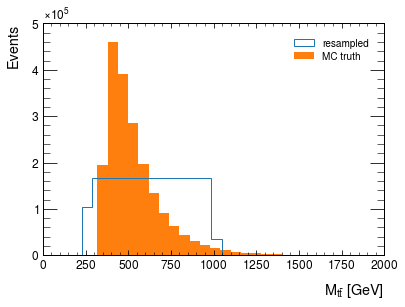

In [31]:
#RESAMPLE, just use uniform distrib and fill with N_evts from y_train? 
uniform_min = 250*1000
uniform_max = 1000*1000

num_samples = len(y_train)

resampled_y_train = np.random.uniform(uniform_min, uniform_max, size=num_samples)
plt.hist(resampled_y_train/1000, histtype="step", range=(100, 2000), bins=30, label="resampled")
plt.hist(y_train/1000, range=(200,2000), bins=30, label="MC truth")
plt.legend()
plt.xlabel(r'$\mathrm{M_{t\bar{t}}}$ [GeV]')
plt.ylabel("Events")

In [ ]:
#history = model.fit(X_train, resampled_y_train, validation_data=(X_test, y_test), batch_size=1024, epochs=100,verbose=1)  #RESAMPLED y_train

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=1024, epochs=100, sample_weight=sample_weights,verbose=1) #WITH WEIGHTS

Epoch 1/100
1929/1929 [==============================] - 17s 8ms/step - loss: 0.3654 - mae: 82604.8281 - val_loss: 23900.0762 - val_mae: 76993.0391
Epoch 2/100
1929/1929 [==============================] - 15s 8ms/step - loss: 0.2071 - mae: 77210.6562 - val_loss: 24153.3555 - val_mae: 76234.5547
Epoch 3/100
1929/1929 [==============================] - 15s 8ms/step - loss: 0.1979 - mae: 76207.2188 - val_loss: 23532.8438 - val_mae: 76577.8984
Epoch 4/100
1929/1929 [==============================] - 15s 8ms/step - loss: 0.1990 - mae: 76442.6797 - val_loss: 23370.5352 - val_mae: 75770.9609
Epoch 5/100
1929/1929 [==============================] - 15s 8ms/step - loss: 0.2065 - mae: 77581.3516 - val_loss: 28595.0371 - val_mae: 88594.7031
Epoch 6/100
1929/1929 [==============================] - 15s 8ms/step - loss: 0.1994 - mae: 76669.3984 - val_loss: 23529.2012 - val_mae: 75533.0625
Epoch 7/100
1929/1929 [==============================] - 16s 8ms/step - loss: 0.1959 - mae: 76279.3359 - val_los

Text(0, 1, 'loss')

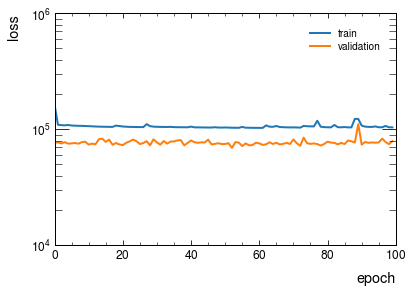

In [33]:
plt.plot(history.epoch,history.history['loss'],label='train')
plt.plot(history.epoch,history.history['val_loss'],label='validation')
plt.legend()
plt.semilogy()
plt.xlabel('epoch')
plt.ylabel('loss')

15429/15429 [==============================] - 20s 1ms/step


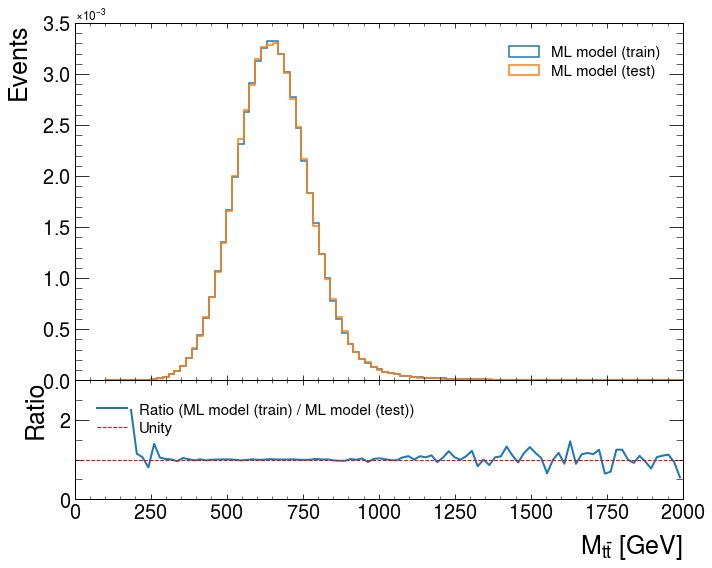

In [34]:
plt.hist(model.predict(X_train)/1000,histtype='step',range=(200,2000),bins=100, label='ML model (train)',density=False)
plt.hist(model.predict(X_test)/1000,histtype='step',range=(200,2000),bins=100, label='ML model (test)',density=False)
plt.legend()
plt.xlabel(r'$\mathrm{M_{t\bar{t}}}$ [GeV]')
plt.ylabel(r'Events')

15429/15429 [==============================] - 20s 1ms/step


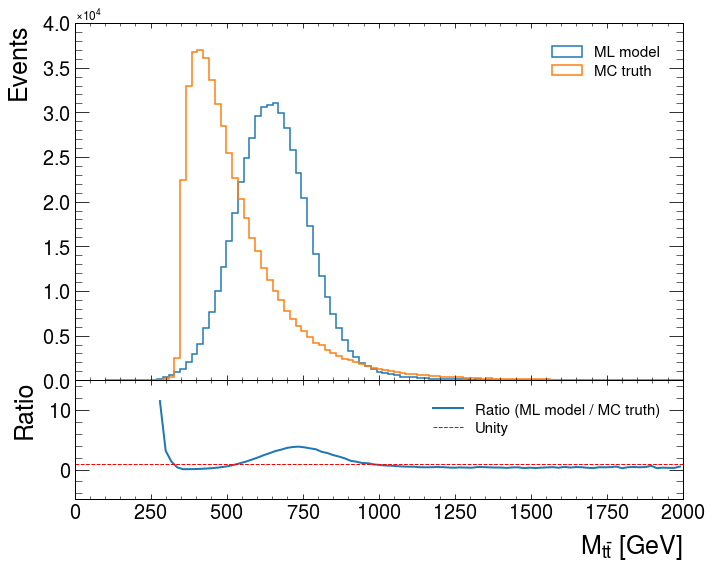

In [35]:
plt.hist(model.predict(X_test)/1000,histtype='step',range=(200,2000),bins=100, label='ML model',density=False)
plt.hist(y_test/1000,histtype='step',range=(200,2000),bins=100, label='MC truth' ,density=False)
plt.legend()
plt.xlabel(r'$\mathrm{M_{t\bar{t}}}$ [GeV]')
plt.ylabel(r'Events')

In [ ]:
plt.hist(model.predict(X_test).reshape(-1)/1000-y_test/1000,histtype='step',range=(-600,600),bins=40,label="ML model" ,density=True)
plt.xlabel(r'$\mathrm{M_{t\bar{t}}^{reco}-M_{t\bar{t}}^{truth}}$ [GeV]')
plt.ylabel(r'Fraction of events')
plt.legend()
print("n_events:", len(y_test)+len(y_train))
print("lowest mean average error of ML:", min(history.history["mae"]))
print("Mean:", np.mean(model.predict(X_test).reshape(-1)/1000-y_test/1000))
print("Std:", np.std(model.predict(X_test).reshape(-1)/1000-y_test/1000))

In [ ]:
plt.hist((model.predict(X_test).reshape(-1)/1000-y_test/1000)/(y_test/1000),histtype='step',range=(-1,1),bins=100)
plt.xlabel(r'$\mathrm{(M_{t\bar{t}}^{reco}-M_{t\bar{t}}^{truth})/M_{t\bar{t}}^{truth}}$ [GeV]')
plt.ylabel(r'Fraction of events')

15429/15429 [==============================] - 20s 1ms/step
Pearson coefficient: 0.8467029861261112


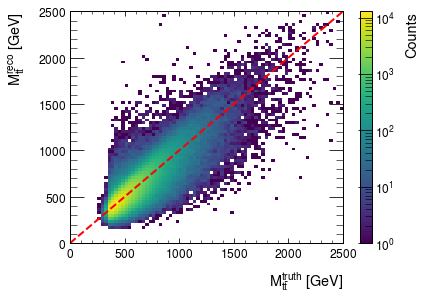

In [29]:
#check correlation overall
maxi = 2500 #xmax=ymax(GeV)
plt.hist2d(y_test/1000, model.predict(X_test).reshape(-1)/1000, bins = (80, 80), range = [(0, maxi), (0, maxi)], norm=mpl.colors.LogNorm(), cmin=0.000000001)
plt.colorbar(label='Counts')
plt.plot([0, maxi], [0, maxi], color='red', linestyle='--')
plt.xlabel(r'$\mathrm{M_{t\bar{t}}^{truth}}$ [GeV]')
plt.ylabel(r'$\mathrm{M_{t\bar{t}}^{reco}}$ [GeV]')

#Pearson coefficient
d1 = model.predict(X_test).reshape(-1)/1000
d2 = y_test/1000
p = (np.cov(d1, d2))[1,0] / (np.std(d1)*np.std(d2))
print("Pearson coefficient:", p)

30229/30229 [==============================] - 36s 1ms/step


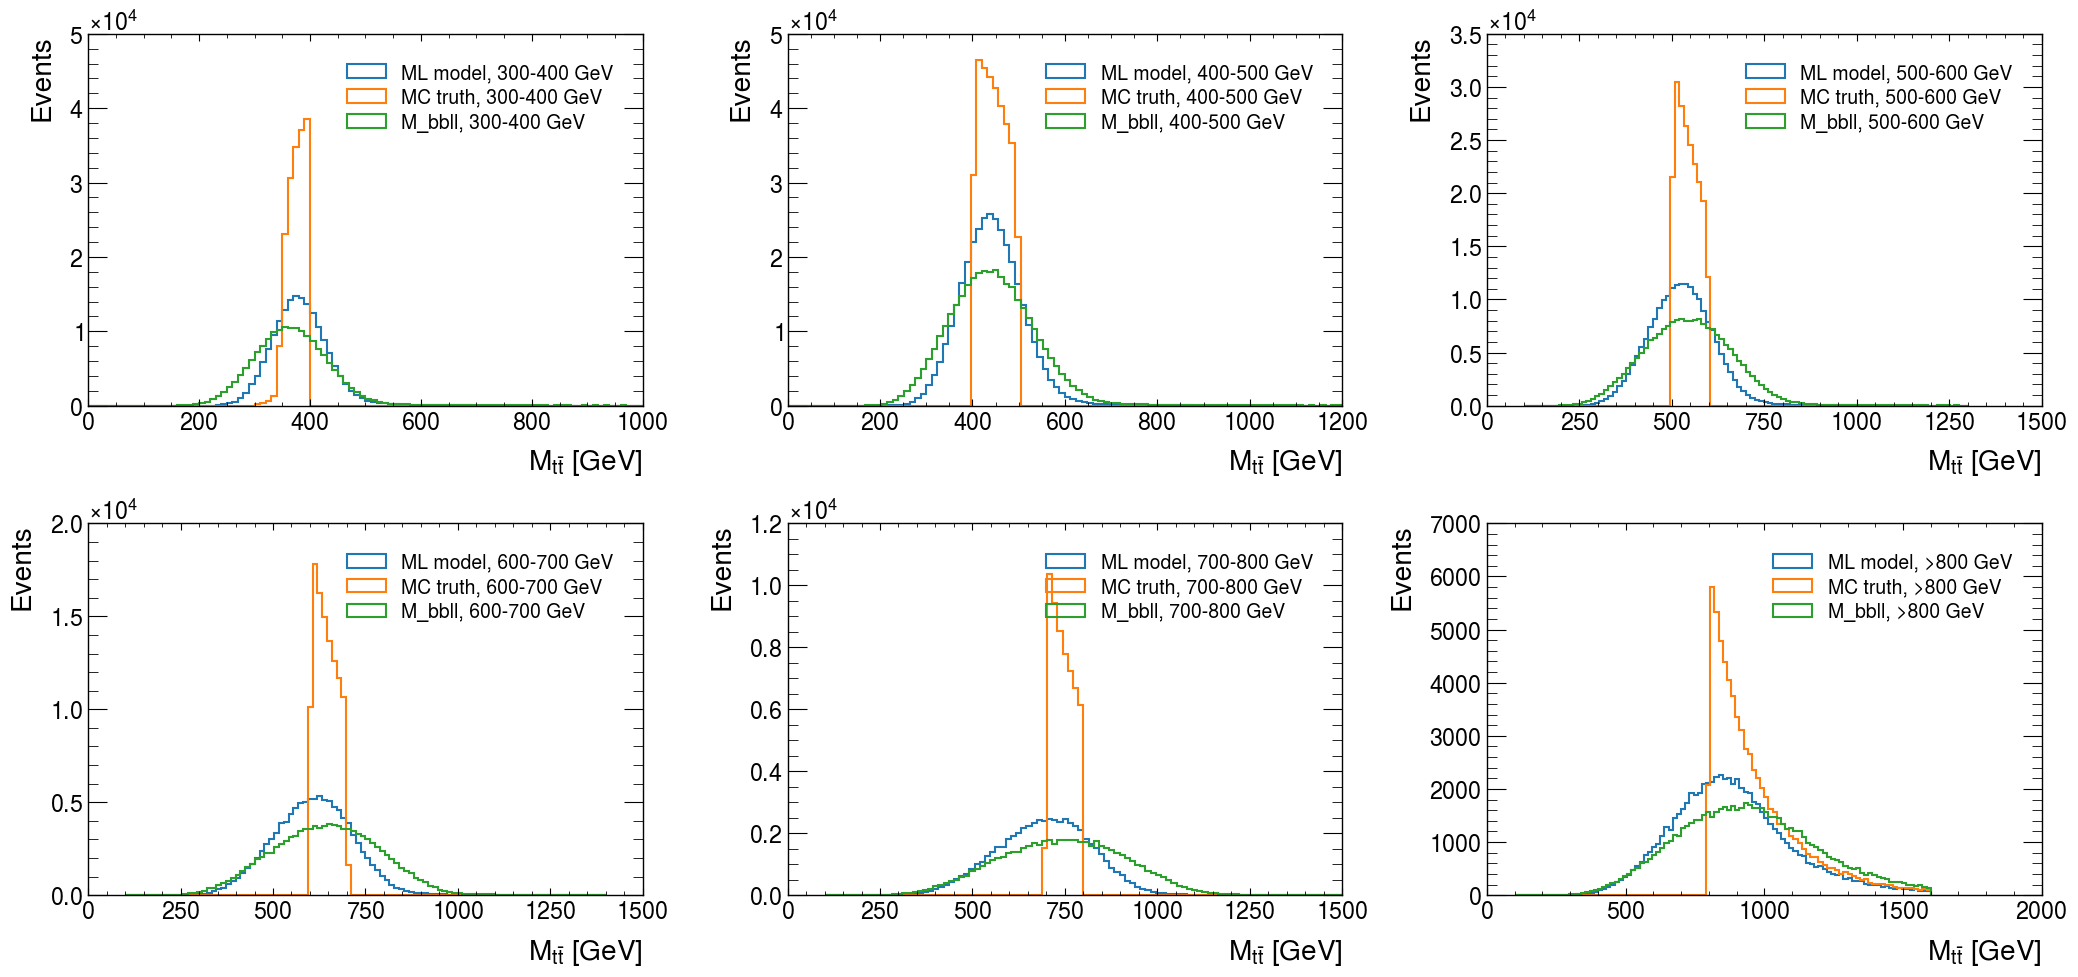

In [81]:
#check bias
###first, whole X_test over 3 intervals###
#set truth into 3 vals
range1 = (y_test/1000 > 300) & (y_test/1000 <= 400) 
range2 = (y_test/1000 > 400) & (y_test/1000 <= 500) 
range3 = (y_test/1000 > 500) & (y_test/1000 <= 600) 
range4 = (y_test/1000 > 600) & (y_test/1000 <= 700) 
range5 = (y_test/1000 > 700) & (y_test/1000 <= 800) 
range6 = (y_test/1000 > 800) 

y_test1 = y_test[range1]
y_test2 = y_test[range2]
y_test3 = y_test[range3]
y_test4 = y_test[range4]
y_test5 = y_test[range5]
y_test6 = y_test[range6]

m_bbll_train, m_bbll_test = train_test_split(m_bbll/1000, test_size=0.2, random_state=42)
scale_factor = np.mean(y_test/1000) / np.mean(m_bbll_test)
m_bbll1 = m_bbll_test[range1]*scale_factor
m_bbll2 = m_bbll_test[range2]*scale_factor
m_bbll3 = m_bbll_test[range3]*scale_factor
m_bbll4 = m_bbll_test[range4]*scale_factor
m_bbll5 = m_bbll_test[range5]*scale_factor
m_bbll6 = m_bbll_test[range6]*scale_factor
# and plot

data = [(model.predict(X_test)[range1], y_test1, '300-400 GeV'), (model.predict(X_test)[range2], y_test2, '400-500 GeV'), 
         (model.predict(X_test)[range3],y_test3, '500-600 GeV'), (model.predict(X_test)[range4],y_test4, '600-700 GeV'), 
         (model.predict(X_test)[range5],y_test5, '700-800 GeV'), (model.predict(X_test)[range6],y_test6, '>800 GeV')]
m_bbll_data = [m_bbll1, m_bbll2, m_bbll3, m_bbll4, m_bbll5, m_bbll6]
range_settings = [(0, 1000), (0, 1200), (100, 1300), (100, 1400), (100, 1500), (100, 1600)]

fig, axes = plt.subplots(2, 3, figsize=(21, 10))
axes = axes.flatten()
for i, (y_pred, y_true, title) in enumerate(data):
    ax = axes[i]
    ax.hist(y_pred/1000, histtype='step', range=range_settings[i], bins=100, label=f'ML model, {title}', density=False, linewidth=1.5)
    ax.hist(y_true/1000, histtype='step', range=range_settings[i], bins=100, label=f'MC truth, {title}', density=False, linewidth=1.5)
    ax.hist(m_bbll_data[i], histtype='step', range=range_settings[i], bins=100, label=f'M_bbll, {title}', density=False, linewidth=1.5)
    ax.legend()
    ax.set_xlabel(r'$\mathrm{M_{t\bar{t}}}$ [GeV]')
    ax.set_ylabel('Events')
plt.tight_layout()

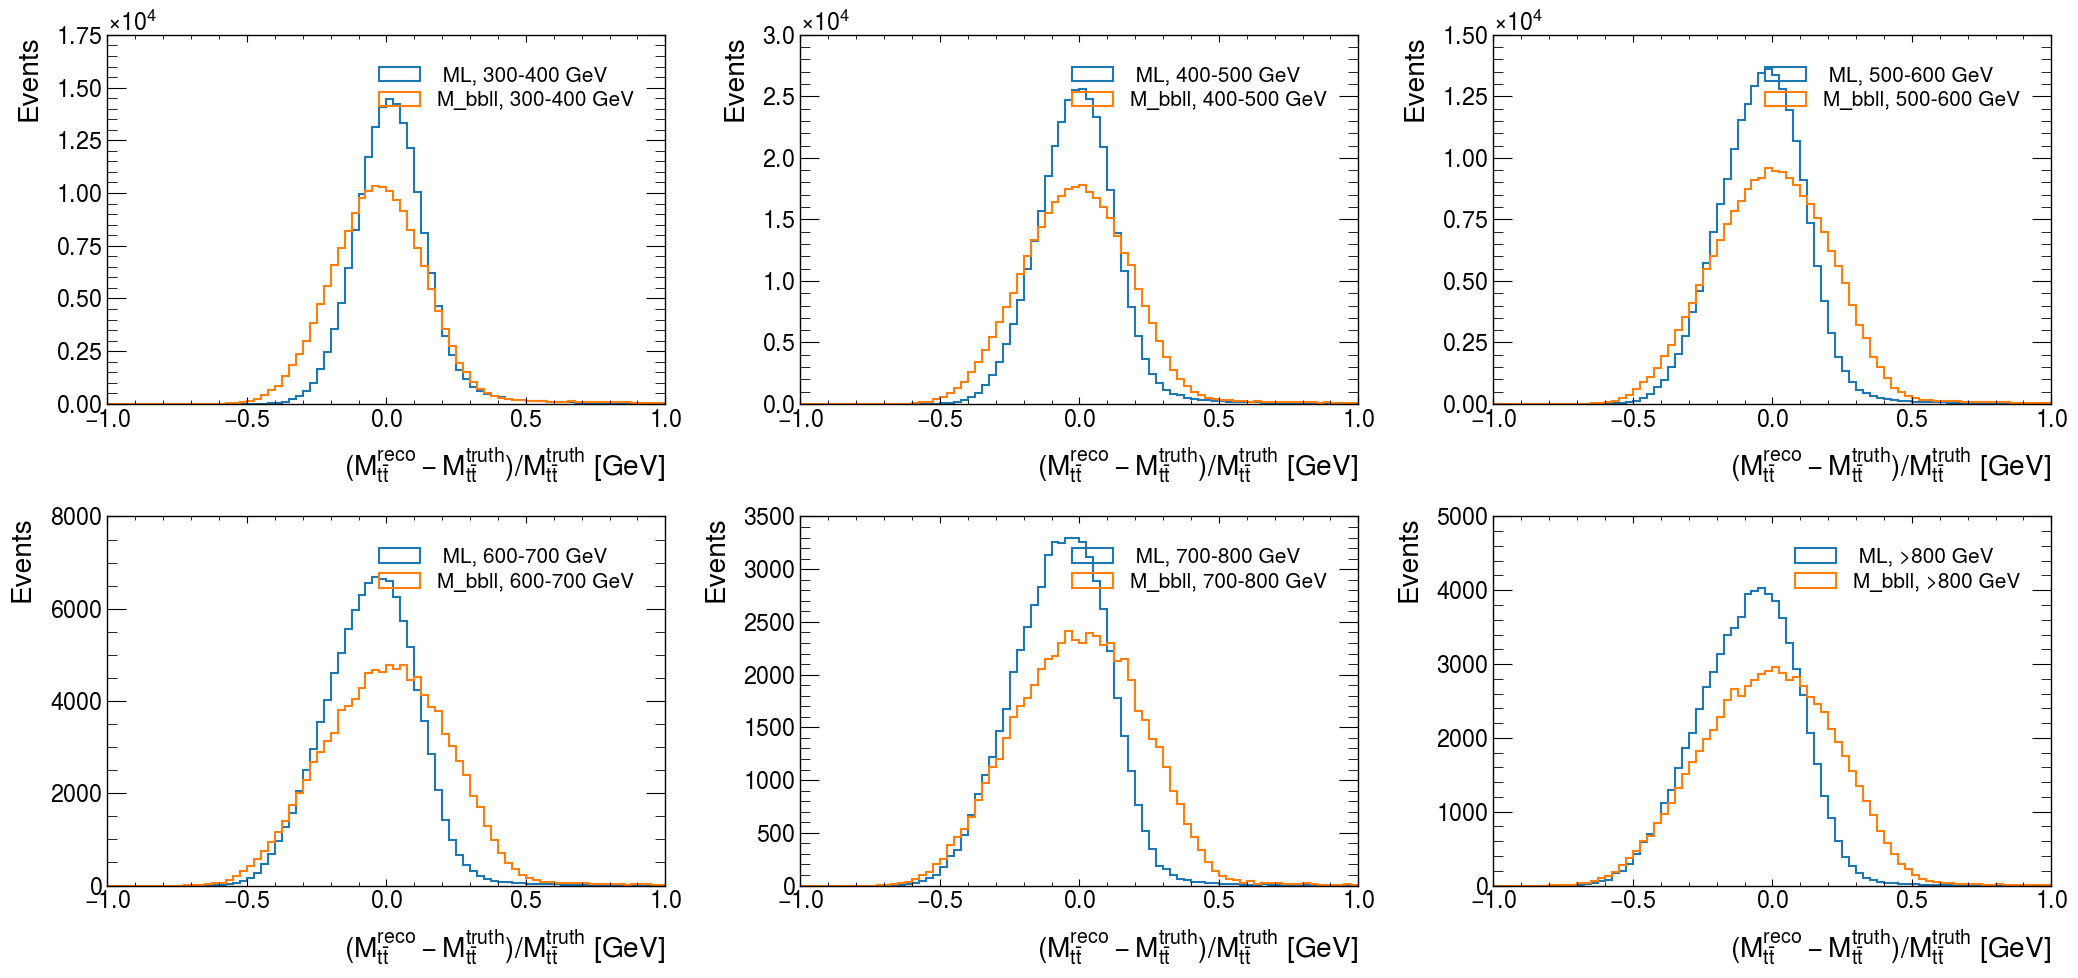

In [82]:
fig, axes = plt.subplots(2, 3, figsize=(21, 10))
axes = axes.flatten()
for i, (y_pred, y_true, title) in enumerate(data):
    ax = axes[i]
    ax.hist((y_pred.reshape(-1)/1000-y_true/1000)/(y_true/1000),histtype='step',range=(-1, 1),bins=80, label=f' ML, {title}', density=False, linewidth=1.5)
    ax.hist((m_bbll_data[i]-y_true/1000)/(y_true/1000),histtype='step',range=(-1, 1),bins=80, label=f'M_bbll, {title}', density=False, linewidth=1.5)
    ax.legend(fontsize="15")
    #ax.set_xlabel(r'$\mathrm{M_{t\bar{t}}^{reco}-M_{t\bar{t}}^{truth}}$ [GeV]')
    ax.set_xlabel(r'$\mathrm{(M_{t\bar{t}}^{reco}-M_{t\bar{t}}^{truth})/M_{t\bar{t}}^{truth}}$ [GeV]')
    ax.set_ylabel(r'Events')
    
plt.tight_layout()

30229/30229 [==============================] - 36s 1ms/step


Text(0, 1, 'fraction of events')

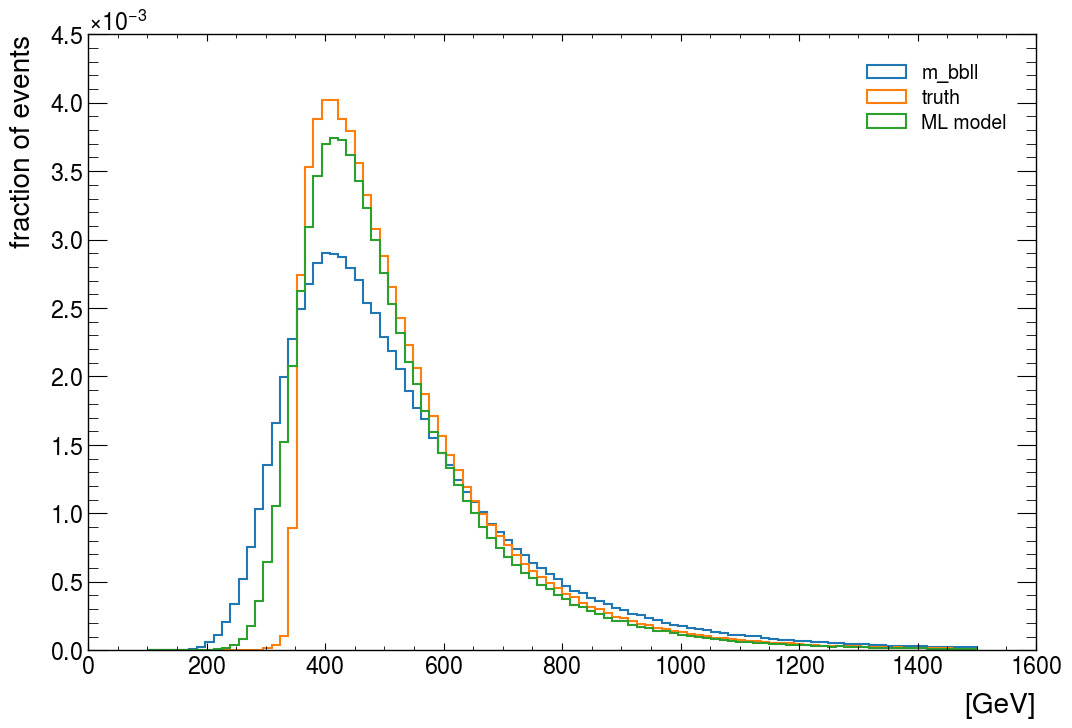

In [79]:
#look vs m_bbll
m_bbll_train, m_bbll_test = train_test_split(m_bbll/1000, test_size=0.2, random_state=42)

scale_factor = np.mean(y_test/1000) / np.mean(m_bbll_test)
m_bbll_scaled = m_bbll_test * scale_factor

fig = plt.figure(figsize=(12,8))
plt.hist(m_bbll_scaled,histtype='step',range=(100,1500),bins=100, label="m_bbll",density=True, linewidth=1.5)
plt.hist(y_test/1000,histtype='step',range=(100,1500),bins=100, label='truth',density=True, linewidth=1.5)
plt.hist(model.predict(X_test)/1000,histtype='step',range=(100,1500),bins=100, label='ML model',density=True, linewidth=1.5)
plt.legend()
plt.xlabel(r'[GeV]')
plt.ylabel(r'fraction of events')

30229/30229 [==============================] - 38s 1ms/step
Importance Score for mu_eta: 11776.0
Importance Score for mu_phi: 7168.0
Importance Score for bjet1_eta: 6656.0
Importance Score for bjet2_phi: 5120.0
Importance Score for bjet1_phi: 29184.0
Importance Score for el_eta: 29696.0
Importance Score for bjet2_eta: 52224.0
Importance Score for el_phi: 54784.0
Importance Score for met_phi: 104960.0
Importance Score for bjet1_e: 14395392.0
Importance Score for el_e: 14647808.0
Importance Score for bjet2_e: 21941248.0
Importance Score for mu_e: 28195328.0
Importance Score for bjet1_pt: 63698944.0
Importance Score for el_pt: 218792448.0
Importance Score for mu_pt: 279603712.0
Importance Score for bjet2_pt: 293142016.0
Importance Score for m_eb2: 1004150784.0
Importance Score for m_mub2: 1024612864.0
Importance Score for met: 1626463744.0
Importance Score for m_mub1: 4399949312.0
Importance Score for m_eb1: 4568084992.0
Importance Score for m_b1b2: 9151967232.0
Importance Score for m_emu

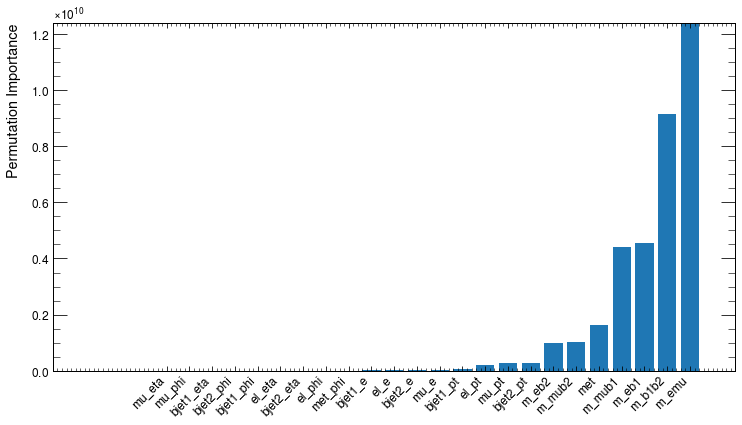

In [17]:
from sklearn.metrics import mean_squared_error
#look at parameter importance
def permutation_importance(model, X, y, metric, n_permutations=10000):
    baseline_score = metric(y, model.predict(X))
    importance_scores = []
    for feature in range(X.shape[1]):
        permuted_X = X.copy()
        permuted_X[:, feature] = np.random.permutation(permuted_X[:, feature])

        permuted_score = metric(y, model.predict(permuted_X))
        importance_scores.append(baseline_score - permuted_score)

    return np.array(importance_scores)
metric = mean_squared_error

importance_scores = permutation_importance(model, X_test, y_test, metric)
feature_names = ["bjet1_pt", "bjet1_eta", "bjet1_phi", "bjet1_e", "bjet2_pt", "bjet2_eta", "bjet2_phi", "bjet2_e", 'el_pt', 'el_eta', 'el_phi', 'el_e','mu_pt', 'mu_eta', 'mu_phi', 'mu_e',
                 'm_emu', 'm_eb1', 'm_eb2', 'm_mub1', 'm_mub2', 'm_b1b2', 'met', 'met_phi']

sorted_indices = np.argsort(importance_scores)[::-1]
plt.figure(figsize=(12, 6))
plt.bar(range(len(importance_scores)), np.abs(importance_scores[sorted_indices]))
plt.xticks(range(len(importance_scores)), labels=np.array(feature_names)[sorted_indices], rotation=45, ha="right")
plt.ylabel('Permutation Importance')
plt.ylim(0, np.max(np.abs(importance_scores[sorted_indices])) + 0.1) 

for index in sorted_indices:
    print(f"Score for {feature_names[index]}: {np.abs(importance_scores[index])}")